# Consistent Bayes: Harmonic Oscillator Example (Parallelized)
---

Copyright 2018 Michael Pilosov


### Import Libraries


In [63]:
from matplotlib import pyplot as plt

import numpy as np

In [64]:
import ipyparallel as ipp # import the client
rc = ipp.Client()
dv = rc[:]
rc.ids # list the ids of the engine the client can communicate with

/home/mpilosov/anaconda3/envs/test_py_env/lib/python3.6/site-packages/ipyparallel/client/client.py:458: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@math-ws-204')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


[0, 1, 2, 3, 4, 5]

In [3]:
%%px
import numpy as np
from cbayes import sample, solve, distributions
lambda_ref = np.array([[0, 1]])

def MSE_generator(model, obs_data, sigma=1):   # this generates a sum of squared residuals.
    def QoI_fun(inputs): # that conforms to our desired model input
        M = len(obs_data)
        predictions = model(inputs)
        assert predictions.shape[1] == M
        residuals = predictions - obs_data
        QoI = (1./M)*np.sum( (residuals/sigma)**2, axis=1 )
        return QoI
    return QoI_fun

# The model of the harmonic oscillator 
def makemodel(t):
    def model(lam = lambda_ref ):
#         return np.cos(lam[:,1]*t + np.arccos(lam[:,0]) )
        QoI = np.cos(np.outer(lam[:,1],t) + np.arccos(lam[:,0]).reshape(len(lam[:,0]),1) )
        if QoI.shape[0] == 1:
            return QoI.ravel() # this allows support for simpler 1D plotting.
        else:
            return QoI
    return model


In [4]:
num_samples = np.linspace(5E3, 25E3, 5)
num_observations = 2**np.linspace(0,8,9)
true_observational_variance = 0.1/np.linspace(4,8,5) # 0.1/6 is true
perceived_observational_variance = 0.1/np.linspace(4,8,5) 
window_length = np.linspace(5,40,8)
S = np.array([ num_observations, true_observational_variance, perceived_observational_variance, window_length])
num_iterations = np.prod([ S[i].shape[0] for i in range(S.shape[0]) ])
SS = np.array( np.meshgrid(*S) )
trial_vector = SS.ravel().reshape(S.shape[0],num_iterations).T
print(trial_vector[0:5,:])
print("Number of total trials:", num_iterations)

[[ 1.     0.025  0.025  5.   ]
 [ 1.     0.025  0.025 10.   ]
 [ 1.     0.025  0.025 15.   ]
 [ 1.     0.025  0.025 20.   ]
 [ 1.     0.025  0.025 25.   ]]
Number of total trials: 1800


# Example Summary

---

The second example is defined by the model for a harmonic oscillator given by the initial value problem  

\begin{equation}
	\begin{cases}
		\frac{d^2u}{dt^2} &= -\lambda_2^2 u, \ t>0, \\
		u(0) &= \lambda_1. 
	\end{cases}
\end{equation}

Choosing a particular parameter $\lambda=(\lambda_1,\lambda_2)\in\Lambda\subset[-1,1]\times\mathbb{R}^+$ corresponds to fixing an initial condition, $\lambda_1\in[-1,1]$, and frequency of oscillation, $\lambda_2$, where we again assume that $\lambda_2>0$.

The solution to the above is
\begin{equation}
	u(t) = \cos(\lambda_2 t + \arccos(\lambda_1)).
\end{equation}

---
## Define Functions

In [5]:
%%px
mins = np.array([-0.005, 0.9])
maxs = np.array([.005, 1.1])
nbins = 100
def grid(nbins=5, mins=np.zeros(1), maxs=np.ones(1) ):
    dim = len(mins)
    S = np.array( np.meshgrid(*[np.linspace(i,j,nbins) for i,j in zip(mins+1./(2*nbins), maxs-1./(2*nbins))]) )
    SS = S.ravel().reshape(dim,nbins**dim).T
    return SS
X = grid(nbins, mins, maxs)

def run_trial(trial):
    num_samples = int(1E4)
    num_observations, sd_true, sd_guess, max_time = trial
    num_observations = int(num_observations)
    num_samples = int(num_samples)
    
    t = np.linspace(0, max_time, num_observations)
    model = makemodel(t)
    u_true = model()
    obs_data = u_true + np.random.randn(int(num_observations))*sd_true
    PtO_fun = MSE_generator(model, obs_data, sd_guess)
    
    s_set = sample.sample_set(size=(num_samples, 2))
    s_set.set_dist('beta', kwds={'a': 1, 'b': 1, 'loc': -0.25, 'scale': 0.5}, dim=0) # initial condition
    s_set.set_dist('beta', kwds={'a': 1, 'b': 1, 'loc': .5, 'scale': 1}, dim=1) # frequency
    s_set.generate_samples()
    p_set = sample.map_samples_and_create_problem(s_set, PtO_fun)
    p_set.compute_pushforward_dist()
    p_set.set_observed_dist('gamma', {'a':num_observations/2, 'scale':2/num_observations}, dim=0)
    p_set.set_ratio()
    #     solve.problem(p_set) # if you care to perform accept/reject on the prior, uncomment this.
#     accept_inds = p_set.accept_inds
#     lam_accept = p_set.input.samples[accept_inds,:]
#     num_accept = len(accept_inds)
#     print('Number accepted: %d = %2.2f%%'%(num_accept, 100*np.float(num_accept)/num_samples))
    
    # Perform accept/reject on that grid you see plotted above.
    Y = PtO_fun(X)
    inds = solve.perform_accept_reject(X, p_set.compute_ratio(Y))
    abs_error = [*np.abs( lambda_ref[0,:] - np.mean(X[inds,:],axis=0) )]
    rel_error = [*np.abs( p_set.observed_dist.mean()-np.mean(Y[inds],axis=0))/p_set.observed_dist.mean() , *np.abs( p_set.observed_dist.std()-np.std(Y[inds],axis=0))/p_set.observed_dist.std()]
#     print('Abs Error in Parameter and MAP:', abs_error )
#     print('Param. Test Stats for Gamma Dist:', rel_error)
#     print(' ')
    
    post_eval = p_set.evaluate_posterior(X)
    return {'p': post_eval, 'a': abs_error, 'r': rel_error, 'n': len(inds), 't': trial}


In [6]:
dv.scatter('trial_chunk', trial_vector)

<AsyncResult: scatter>

In [ ]:
%%capture output
%%px
D = list(map(run_trial, trial_chunk))

In [30]:
output.show()

In [31]:
Dg = np.array(list(dv.gather('D').get() ))
np.save("savefile_gridsearch.npy", Dg)

In [95]:
Dg = np.load("savefile_gridsearch.npy")
# Make the plot
xi = X[:,0].reshape(nbins, nbins)
yi = X[:,1].reshape(nbins, nbins)
post_eval = Dg[200]['n']
zi = post_eval.reshape(nbins, nbins)
plt.pcolormesh(xi, yi, zi/np.max(zi))
# plt.scatter(lam_true[0,0], lam_true[0,1], c='white', edgecolor='black', s=50)
plt.show()

AttributeError: 'int' object has no attribute 'reshape'

In [96]:
Dg[200]['n']

62

In [72]:
from scipy.stats import entropy
# %matplotlib inline
# %matplotlib notebook
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = 20, 10

0.0


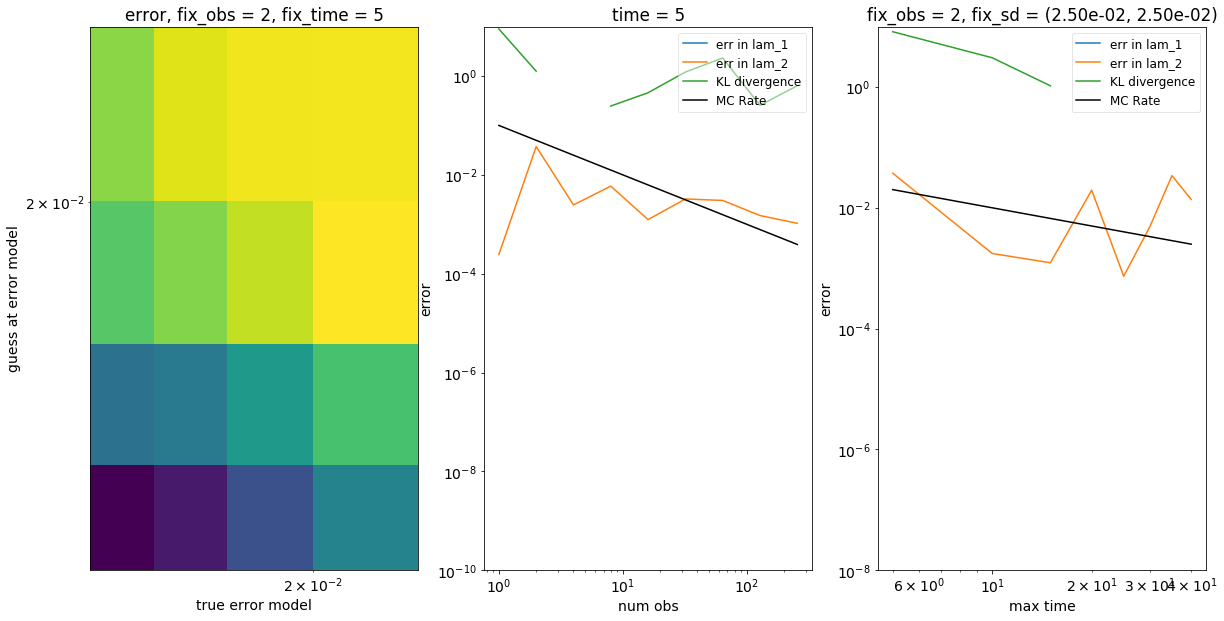

In [49]:
# Dg = np.load("savefile_gridsearch.npy")
E = []
T = []
T0 = []
fix_time = int(window_length[0])
fix_obs = int(num_observations[1])
fix_sd_true = 0.1/4
fix_sd_guess = 0.1/4
for D in Dg:
    n = int(D['n'])
    sample_err_1 = D['a'][0]
    sample_err_2 = D['a'][1]
    pf_rel_err_mean = D['r'][0]
    pf_rel_err_std = D['r'][1]
    num_obs, sd_true, sd_guess, max_time = D['t']
    if sd_true == fix_sd_true and sd_guess == fix_sd_guess and max_time == fix_time:
        if num_obs == num_observations[0]:
            T0.append([ num_obs, entropy(D['p']), sample_err_1, sample_err_2 ])
            ref = D['p']
        else:
            T0.append([ num_obs, entropy(D['p'],ref), sample_err_1, sample_err_2 ])
#             print(entropy(D['p'], ref))
#             print(pf_rel_err_mean)
            ref = D['p']
    if num_obs == fix_obs and max_time == fix_time:
        T.append([sd_true, sd_guess, pf_rel_err_mean, pf_rel_err_std])
    
    if num_obs == fix_obs and sd_true == fix_sd_true and sd_guess == fix_sd_guess:
        if max_time == window_length[0]:
            E.append([ max_time, entropy(D['p']), sample_err_1, sample_err_2 ])
            ref = D['p']
        else:
            E.append([ max_time, entropy(D['p'],ref), sample_err_1, sample_err_2 ])
            ref = D['p']
            
E = np.array(E)
T = np.array(T)
T0 = np.array(T0)
plt.close('all')
plt.subplots(1,3)

plt.subplot(131)
xi = T[:,0].reshape(len(true_observational_variance),len(perceived_observational_variance))
yi = T[:,1].reshape(len(true_observational_variance),len(perceived_observational_variance))
zi = T[:,3].reshape(len(true_observational_variance),len(perceived_observational_variance))
plt.pcolormesh(xi, yi, zi)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('guess at error model')
plt.xlabel('true error model')
plt.title('error, fix_obs = %d, fix_time = %d'%(fix_obs, fix_time))
plt.savefig('testfig.png')

plt.subplot(132)
plt.cla()
plt.plot(T0[:,0], T0[:,2], label='err in lam_1')
print(np.max(T0[:,2]))
plt.plot(T0[:,0], T0[:,3], label='err in lam_2')
plt.plot(T0[:,0], T0[:,1], label='KL divergence')
plt.plot(num_observations, .1/num_observations, label='MC Rate', c='k')

plt.legend(fontsize=12, framealpha=0.5,loc='upper right')
plt.title('time = %d'%fix_time)
plt.yscale('log')
plt.xscale('log')
plt.ylim([1E-10, 10])
plt.xlabel('num obs')
plt.ylabel('error')

plt.subplot(133)
plt.cla()
plt.plot(E[:,0], E[:,2], label='err in lam_1')
plt.plot(E[:,0], E[:,3], label='err in lam_2')
plt.plot(E[:,0], E[:,1], label='KL divergence')
plt.plot(window_length, .1/window_length, label='MC Rate', c='k')

plt.legend(fontsize=12, framealpha=0.5,loc='upper right')
plt.title('fix_obs = %d, fix_sd = (%.2e, %.2e)'%(fix_obs, fix_sd_true, fix_sd_guess))
plt.yscale('log')
plt.xscale('log')
plt.ylabel('error')
plt.ylim([1E-8, 10])
plt.xlabel('max time')

plt.show()


In [39]:
zi

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

Text(0,0.5,'error')

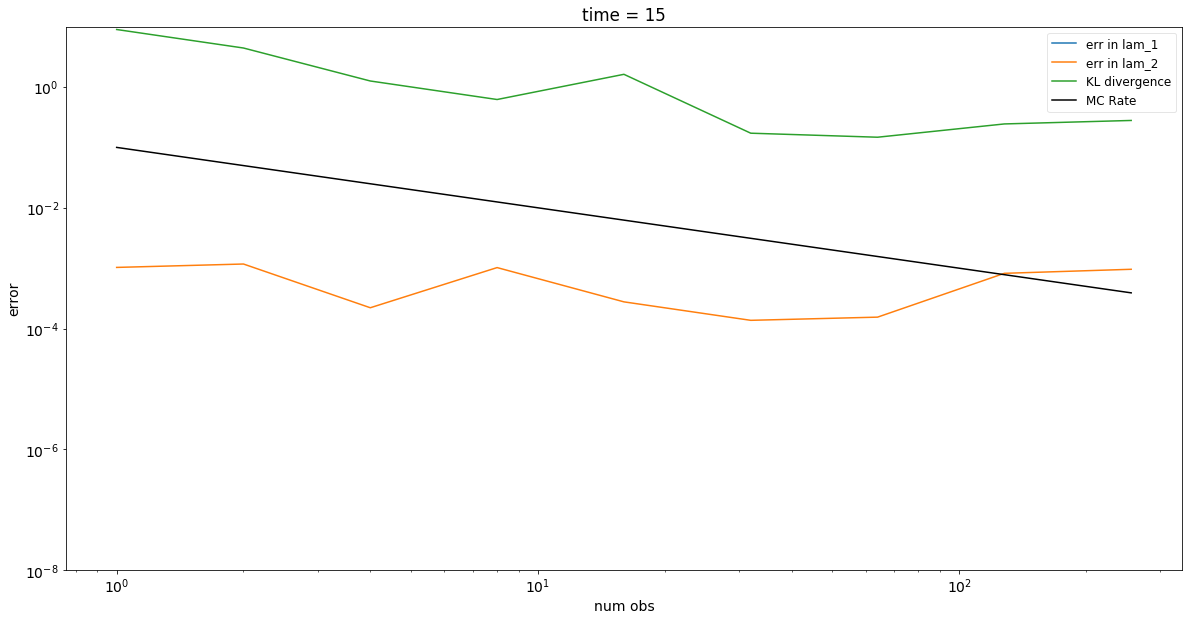

In [22]:
plt.cla()
plt.plot(T0[:,0], T0[:,2], label='err in lam_1')
plt.plot(T0[:,0], T0[:,3], label='err in lam_2')
plt.plot(T0[:,0], T0[:,1], label='KL divergence')
plt.plot(num_observations, .1/num_observations, label='MC Rate', c='k')

plt.legend(fontsize=12, framealpha=0.5,loc='upper right')
plt.title('time = %d'%fix_time)
plt.yscale('log')
plt.xscale('log')
plt.ylim([1E-8, 10])
plt.xlabel('num obs')
plt.ylabel('error')